In [71]:
import pandas as pd
import numpy as np
import os
import requests
from tqdm import tqdm
import shutil

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython

In [72]:
%%time
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CPU times: user 17.6 ms, sys: 0 ns, total: 17.6 ms
Wall time: 1.64 s


In [73]:
%%time
!unzip "/content/drive/MyDrive/Images for project.zip"

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: Images for project/acrodermatitis_enteropathica45.jpg  
  inflating: Images for project/granuloma_annulare93.jpg  
  inflating: Images for project/ichthyosis_vulgaris45.jpg  
  inflating: Images for project/img?imageId=8465  
  inflating: Images for project/carcinome_basocellulaire_nodulaire3.jpg  
  inflating: Images for project/giant_congenital_nevus10.jpg  
  inflating: Images for project/herpes_gestationis22.jpg  
  inflating: Images for project/kaposis-sarcoma54.jpg  
  inflating: Images for project/img?imageId=2963  
  inflating: Images for project/img?imageId=8657  
  inflating: Images for project/img?imageId=5148  
  inflating: Images for project/mycosis-fongoide25.jpg  
  inflating: Images for project/hidradenitis_suppurativa43.jpg  
  inflating: Images for project/img?imageId=5974  
  inflating: Images for project/syringoma18.jpg  
  inflating: Images for project/stasis-dermatitis37.jpg  
  infla

In [74]:
url = 'https://raw.githubusercontent.com/ontenkutsenko/DL_Skin_Desease_Classification/main/fitzpatrick17k.csv'
df = pd.read_csv(url).dropna(subset = ['url'])
df = df.sample(frac=1, random_state=10).reset_index(drop=True)

In [75]:
df['rank'] = df.groupby(['label', 'fitzpatrick_scale']).cumcount()/(df.groupby(['label', 'fitzpatrick_scale']).transform('count')['url'] - 1)

In [76]:
def assign_split(row, proportion):
    if row['rank'] < proportion['train']:
        return 'train'
    elif row['rank'] < proportion['train']+proportion['test']:
        return 'test'
    else:
        return 'val'

In [77]:
proportion = {
    'train': 0.75,
    'val': 0.05,
    'test': 0.20
}

df['split'] = df.apply(lambda row: assign_split(row, proportion), axis=1)
df.split.value_counts()/len(df)

train    0.732221
test     0.191945
val      0.075835
Name: split, dtype: float64

In [78]:
shutil.rmtree('/content/dataset', ignore_errors=True)

In [79]:
source_folder = '/content/Images for project'
destination_folder = '/content/dataset'


for i in range(len(df)):
  try:
    source_file = os.path.join(source_folder, df['url'][i].split('/')[-1])
    destination_file = os.path.join(destination_folder, df['split'][i], df['label'][i], df['url'][i].split('/')[-1])
    os.makedirs(os.path.dirname(destination_file), exist_ok=True)

    shutil.move(source_file, destination_file)
  except:
    print(source_file, ' doesn\'t exist')

/content/Images for project/img?imageId=4030  doesn't exist
/content/Images for project/img?imageId=8364  doesn't exist
/content/Images for project/img?imageId=2767  doesn't exist
/content/Images for project/img?imageId=4031  doesn't exist
/content/Images for project/img?imageId=5399  doesn't exist
/content/Images for project/img?imageId=2766  doesn't exist
/content/Images for project/img?imageId=6724  doesn't exist
/content/Images for project/img?imageId=4505  doesn't exist
/content/Images for project/img?imageId=8362  doesn't exist
/content/Images for project/img?imageId=8363  doesn't exist


In [80]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=60,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_generator = train_datagen.flow_from_directory(
        'dataset/train',
        batch_size=batch_size,
        shuffle = True,
        class_mode='categorical',
        target_size = (224,224))

val_generator = val_datagen.flow_from_directory(
        'dataset/val',
        batch_size=batch_size,
        class_mode='categorical',
        target_size = (224,224))

test_generator = test_datagen.flow_from_directory(
        'dataset/test',
        batch_size=batch_size,
        class_mode='categorical',
        target_size = (224,224))


Found 9250 images belonging to 114 classes.
Found 982 images belonging to 114 classes.
Found 2399 images belonging to 114 classes.


In [81]:
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [82]:
# need to change here

class PlotMetricsCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.accuracies = []
        self.val_accuracies = []

    def on_epoch_end(self, epoch, logs):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracies.append(logs.get('accuracy'))
        self.val_accuracies.append(logs.get('val_accuracy'))

        # Plot loss
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(range(1, epoch + 2), self.losses, label='Training Loss')
        plt.plot(range(1, epoch + 2), self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(range(1, epoch + 2), self.accuracies, label='Training Accuracy')
        plt.plot(range(1, epoch + 2), self.val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()

        # Show plot
        plt.tight_layout()
        plt.show()

# Create an instance of the custom callback
plot_metrics_callback = PlotMetricsCallback()



# Define a LambdaCallback to clear the output
clear_output_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch, logs: IPython.display.clear_output(wait=True)
)


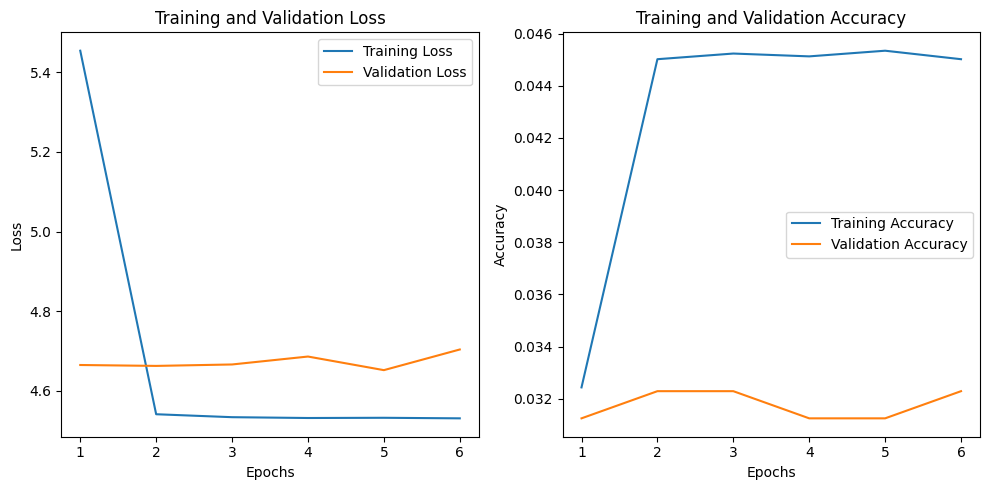

289/289 [==============================] - 154s 533ms/step - loss: 4.5306 - accuracy: 0.0450 - val_loss: 4.7036 - val_accuracy: 0.0323
Epoch 7/10
 95/289 [========>.....................] - ETA: 1:38 - loss: 4.5420 - accuracy: 0.0385

In [ ]:
model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
n_classes = 114

for layer in model.layers[:-4]:
    layer.trainable = False

model = Sequential([
    model,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(n_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,
          validation_data=val_generator,
          epochs=10,
          steps_per_epoch=int(train_generator.n/batch_size),
          validation_steps = int(val_generator.n/batch_size),
          callbacks=[clear_output_callback, plot_metrics_callback])


In [47]:
model.save_weights('/content/drive/MyDrive/Nova IMS/DL/Project/resnet_weights_baseline_19_03.h5')